if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [6]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
INPUT_SHAPE = (184, 80)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [9]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [10]:
import timm

In [11]:
# timm.list_models(pretrained=True)

In [12]:
BACKBONE = 'efficientnet_b1'

In [13]:
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class MaskClassifier(nn.Module):
    def __init__(self):
        super(MaskClassifier, self).__init__()
        self.model = timm.create_model(BACKBONE, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classfier = nn.Linear(n_features, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

## Trainer

In [14]:

class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [16]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

## 학습을 위한 객체 선언

In [17]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=TRAIN_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=TRAIN_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

NameError: name 'DATA_DIR' is not defined

In [18]:
model = MaskClassifier().to(device)

# For Multi-GPU
os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
model = nn.DataParallel(model)

In [33]:

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim. lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=6, T_mult=1, eta_min=1e-6)
# criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

# Set system logger
system_logger = get_logger(name='train',file_path='train_log.log')

# Set trainer
trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)



In [104]:
train_loss_history = []
train_acc_history = []

valid_loss_history = []
valid_acc_history = []

best_val_loss = None
best_val_acc = None

criterion = 1E+8
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    train_loss_history.append(trainer.train_mean_loss)
    train_acc_history.append(trainer.train_score)
    
    valid_loss_history.append(trainer.val_mean_loss)
    valid_acc_history.append(trainer.validation_score)

    # don't use early stopper
    
    if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
        best_val_loss = trainer.val_mean_loss
        criterion = trainer.val_mean_loss
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

best_val_acc = max(valid_acc_history)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 696.2891436799617, Acc: 0.7258897818599311, ROC: 0.8343392157913605


  5%|▌         | 1/20 [03:32<1:07:22, 212.78s/it]

Epoch 0, Val loss: 699.8517084065273, Acc: 0.8649446494464945, ROC: 0.9230664870382256
Epoch 1, Train loss: 696.1793934579283, Acc: 0.8703460718386091, ROC: 0.9264022931989774


 10%|█         | 2/20 [07:10<1:04:46, 215.90s/it]

Epoch 1, Val loss: 699.82394318891, Acc: 0.8985239852398524, ROC: 0.953044490354443
Epoch 2, Train loss: 696.1516143718729, Acc: 0.9073724782680006, ROC: 0.9543071816623566
Epoch 2, Val loss: 699.813872026974, Acc: 0.9081180811808118, ROC: 0.9678582651369276


 15%|█▌        | 3/20 [12:12<1:12:14, 254.98s/it]

Epoch 3, Train loss: 696.1314060081021, Acc: 0.9359111038215516, ROC: 0.9737764072098135


 20%|██        | 4/20 [17:23<1:13:53, 277.11s/it]

Epoch 3, Val loss: 699.7963878022143, Acc: 0.9317343173431735, ROC: 0.974007084848809
Epoch 4, Train loss: 696.1212957587455, Acc: 0.95013941282598, ROC: 0.9794394518707346


 25%|██▌       | 5/20 [20:53<1:03:16, 253.10s/it]

Epoch 4, Val loss: 699.7979104307276, Acc: 0.9250922509225092, ROC: 0.9703094913350448
Epoch 5, Train loss: 696.1139502738091, Acc: 0.9598573068722323, ROC: 0.9858002319309913


 30%|███       | 6/20 [24:52<57:52, 248.03s/it]  

Epoch 5, Val loss: 699.8096627681213, Acc: 0.9107011070110701, ROC: 0.9768018002959634
Epoch 6, Train loss: 696.1093493684383, Acc: 0.9663769066754141, ROC: 0.987709114112361


 35%|███▌      | 7/20 [33:49<1:14:13, 342.59s/it]

Epoch 6, Val loss: 699.8051515838804, Acc: 0.9180811808118081, ROC: 0.9793483008843247
Epoch 7, Train loss: 696.1058679215239, Acc: 0.9708873216335903, ROC: 0.9890694967081526


 40%|████      | 8/20 [49:47<1:47:43, 538.63s/it]

Epoch 7, Val loss: 699.7881798377404, Acc: 0.9402214022140222, ROC: 0.9763137279810299
Epoch 8, Train loss: 696.102240534905, Acc: 0.9762178120387076, ROC: 0.9907254713525001


 45%|████▌     | 9/20 [54:28<1:23:58, 458.09s/it]

Epoch 8, Val loss: 699.7831113916883, Acc: 0.9468634686346864, ROC: 0.9832606796462701
Epoch 9, Train loss: 696.0999745446553, Acc: 0.9790880761030015, ROC: 0.9919402855552882


 50%|█████     | 10/20 [59:29<1:08:14, 409.40s/it]

Epoch 9, Val loss: 699.7840207794009, Acc: 0.9453874538745387, ROC: 0.9796876114320354
Epoch 10, Train loss: 696.0992543778707, Acc: 0.9799901590946367, ROC: 0.9924928516430531
Epoch 10, Val loss: 699.7815595096386, Acc: 0.9490774907749078, ROC: 0.9833492681143917


 55%|█████▌    | 11/20 [1:08:07<1:06:25, 442.88s/it]

Epoch 11, Train loss: 696.0978731570907, Acc: 0.9818353288502543, ROC: 0.9927915468937849


 60%|██████    | 12/20 [1:14:00<55:22, 415.31s/it]  

Epoch 11, Val loss: 699.7826126369499, Acc: 0.9487084870848709, ROC: 0.9813515703002423
Epoch 12, Train loss: 696.0971566748432, Acc: 0.9832294571100542, ROC: 0.9929325052081676


 65%|██████▌   | 13/20 [1:19:13<44:50, 384.32s/it]

Epoch 12, Val loss: 699.7776597604244, Acc: 0.9546125461254612, ROC: 0.9848157136999002
Epoch 13, Train loss: 696.096571153856, Acc: 0.983885517467607, ROC: 0.9937878640120658


 70%|███████   | 14/20 [1:24:20<36:06, 361.07s/it]

Epoch 13, Val loss: 699.788186699681, Acc: 0.9402214022140222, ROC: 0.980344503280559
Epoch 14, Train loss: 696.0956591909013, Acc: 0.9849516155486304, ROC: 0.9932481614197975


 75%|███████▌  | 15/20 [1:27:52<26:20, 316.08s/it]

Epoch 14, Val loss: 699.7812763642983, Acc: 0.951660516605166, ROC: 0.9800600730102697
Epoch 15, Train loss: 696.0946473449546, Acc: 0.9863457438084304, ROC: 0.9943232799192881


 80%|████████  | 16/20 [1:31:23<18:57, 284.50s/it]

Epoch 15, Val loss: 699.7799556213017, Acc: 0.9531365313653136, ROC: 0.9797355272072458
Epoch 16, Train loss: 696.0954661932517, Acc: 0.9852386419550598, ROC: 0.9938948900835812


 85%|████████▌ | 17/20 [1:34:55<13:07, 262.58s/it]

Epoch 16, Val loss: 699.7738781088202, Acc: 0.9601476014760147, ROC: 0.9856444894629867
Epoch 17, Train loss: 696.0938413124385, Acc: 0.9876988682958833, ROC: 0.9946705839766176


 90%|█████████ | 18/20 [1:38:30<08:16, 248.35s/it]

Epoch 17, Val loss: 699.7827679335013, Acc: 0.9487084870848709, ROC: 0.981613435583369
Epoch 18, Train loss: 696.0940068763072, Acc: 0.987534853206495, ROC: 0.9943356514437078


 95%|█████████▌| 19/20 [1:41:57<03:55, 235.96s/it]

Epoch 18, Val loss: 699.7808621197762, Acc: 0.9505535055350554, ROC: 0.982475362376979
Epoch 19, Train loss: 696.0939677481264, Acc: 0.9875758569788421, ROC: 0.994662337440457


100%|██████████| 20/20 [1:45:13<00:00, 315.66s/it]

Epoch 19, Val loss: 699.7795662964589, Acc: 0.9520295202952029, ROC: 0.9813861142312081


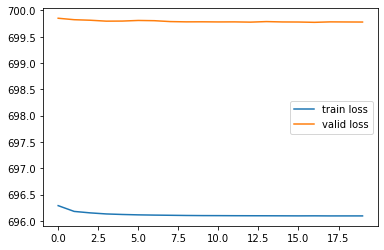

In [105]:
plt.plot(train_loss_history, label="train loss")
plt.plot(valid_loss_history, label="valid loss")
plt.legend()
plt.show()

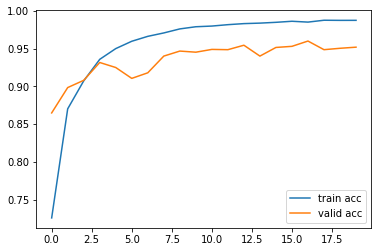

In [106]:
plt.plot(train_acc_history, label="train acc")
plt.plot(valid_acc_history, label="valid acc")
plt.legend()
plt.show()

In [107]:
TIME = datetime.now().strftime('%m%d%H%M%S')

save_dict = {'backbone':BACKBONE,
             'time':TIME,
             'best_val_loss':best_val_loss,
             'best_val_acc':best_val_acc,
             'test_acc':None,
             'epochs':EPOCHS,
             'input_shape':INPUT_SHAPE,
             'augmentation':None,
             'optimizer':'Adam',
             'scheduler':'CosineAnnealingWarmRestarts',
             'attention_module':None,
             'learning_rate':LEARNING_RATE,
             'batch_size':BATCH_SIZE,
             'loss':'CrossEntropyLoss',
             'freeze':None,
             'others':None,
             'randomeseed':seed,
             'train_loss':train_loss_history,
             'train_acc':train_acc_history,
             'valid_loss':valid_loss_history,
             'valid_acc':valid_acc_history}


with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
    json.dump(save_dict, f)

In [108]:
with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'r') as f:
    load_dict = json.load(f)

In [38]:
# load_dict

In [39]:
# check how it looks
# load_dict

In [72]:
save_csv = pd.DataFrame()

In [40]:
save_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [73]:
save_csv = save_csv.append(load_dict, ignore_index=True)

In [74]:
save_csv.to_csv(os.path.join(CSV_DIR, 'experiment.csv'), 
                index=False
               )

In [75]:
load_csv = pd.read_csv(os.path.join(CSV_DIR, 'experiment.csv'))

In [76]:
load_csv

,backbone,time,best_val_loss,best_val_acc,test_acc,epochs,input_shape,augmentation,optimizer,scheduler,...,learning_rate,batch_size,loss,freeze,others,randomeseed,train_loss,train_acc,valid_loss,valid_acc
0,efficientnet_b1,830163729,5.968584,0.959225,NaN,20.0,"[180, 90]",NaN,Adam,CosineAnnealingWarmRestarts,...,0.0001,16.0,CrossEntropyLoss,NaN,NaN,100.0,"[6.233774349995871, 6.050052060686503, 6.01693...","[0.6954977396438786, 0.8654396162007565, 0.897...","[6.078765232887494, 6.029575762664073, 6.00644...","[0.8538745387453874, 0.8990774907749077, 0.923..."


## Inference

In [18]:
TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')

#### Test set Loader

In [19]:
from modules.dataset import TestDataset
from modules.utils import load_yaml, save_csv

In [36]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [27]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [28]:
def test_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [29]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [30]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [31]:
test_dataset = CustomDataset(db=test_db, mode='test', transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_num_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in enumerate(test_dataloader):
        img = img.to(device)
        pred = model(img)
        file_num_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

#### Save results as csv file

In [23]:
df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
df.sort_values(by=['file_name'], inplace=True)
df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

In [24]:
# df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
# df.sort_values(by=['file_name'], inplace=True)
# save_csv(path=(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), obj=df)

In [35]:
trainer.validate_epoch(validation_dataloader, 0)

Epoch 0, Val loss: 699.7743266630455, Acc: 0.9601476014760147, ROC: 0.9856450466231637
